In [16]:
import pandas as pd
import numpy as np

In [17]:
raw = []

In [18]:
from os import listdir
from os.path import isfile, join, isdir

train_foldername = 'authorship-verification/training'
train_folders = [f for f in listdir(train_foldername)]
for f in sorted(train_folders):
    file_dir = train_foldername+'/'+f
    if isdir(file_dir):
        file_path = train_foldername+'/'+f

        unknown = pd.read_csv(file_path+'/'+'unknown.txt', sep="delimiter", header=None, engine='python')[0].str.cat(sep=' ')
        known = pd.read_csv(file_path+'/'+'known01.txt', sep="delimiter", header=None, engine='python')[0].str.cat(sep=' ')

        df = {
            'id': f,
            'unknown' : unknown,
            'known' : known
        }
        raw.append(df)

In [19]:
truth = pd.read_csv(train_foldername+'/'+'truth.txt', sep=" ", header=None, engine='python', names=['id', 'truth'])
truth

,id,truth
0,EN001,Y
1,EN002,N
2,EN003,N
3,EN004,N
4,EN005,Y
...,...,...
95,EN096,N
96,EN097,Y
97,EN098,N
98,EN099,N


In [20]:
raw = pd.DataFrame(raw)
df = pd.merge(raw, truth, on='id')
df

,id,unknown,known,truth
0,EN001,"Oh, he's coming, he's coming. I'm going to get...","My, my, I was forgetting all about the childre...",Y
1,EN002,"But speed thy steps, the cold will work thee i...","Sir, you are sad! The silent eloquence Of yond...",N
2,EN003,But the grub's gittin' low. They's enough to l...,God! What beauty! Umm? I said: God! What bea...,N
3,EN004,"It turns the night to day, it shines so bright...",Sullen night is laughing day-- All the year is...,N
4,EN005,"Who'll it be? Ah, it's Fred Nicholls, maybe. E...",Gimme a shock. Number Two. Same here. Here's l...,Y
...,...,...,...,...
95,EN096,"If 'e keeps quiet, I won't. But I'm not accou...","He's fur me. Scwumptious! Maw, they had a show...",N
96,EN097,"And O my darling, O my pet, Whatever else you ...","In short, if you'd kindle The spark of a swind...",Y
97,EN098,There you go kiddin' again. But you was going ...,"And if I get in my baby buggy, I'll bweak it a...",N
98,EN099,"Of life, alas! his leave he's taking, For ah! ...","You mutt, you! I've stood enough from you. Don...",N


In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv = CountVectorizer(analyzer='char', ngram_range=(3,3))   
# cv = CountVectorizer(analyzer='word')
cv_fit = cv.fit_transform(df['unknown']+ df['known'])    
word_list = cv.get_feature_names_out()
tfidf = TfidfTransformer()
transformed = tfidf.fit_transform(cv_fit)



In [22]:
count_list = np.asarray(cv_fit.sum(axis=0))[0]

frequencies = pd.DataFrame([word_list, count_list]).transpose()
frequencies

,0,1
0,"""a",14
1,"""b",1
2,"""c",1
3,"""d",1
4,"""h",8
...,...,...
5967,} l,1
5968,} m,2
5969,} s,2
5970,} t,2


In [23]:
df[df.unknown.str.contains('_and_')]

,id,unknown,known,truth
62,EN063,"From what he told me, I should say it was the ...",Gimme a shock. Number Two. Same here. Here's l...,Y


In [24]:
frequencies.iloc[:20]

,0,1
0,"""a",14
1,"""b",1
2,"""c",1
3,"""d",1
4,"""h",8
5,"""i",11
6,"""k",2
7,"""l",4
8,"""m",4
9,"""o",9


In [25]:
frequencies.sort_values(by=1, ascending=False)

,0,1
254,th,5255
5180,the,4042
2582,he,3131
5909,you,2652
284,yo,2579
...,...,...
1810,e -,1
4024,ofo,1
1835,e z,1
557,",se",1


[   1  251  501  751 1001 1251 1501 1751 2001 2251 2501 2751 3001 3251
 3501 3751 4001 4251 4501 4751 5001 5251]


(array([5.665e+03, 1.800e+02, 5.500e+01, 3.500e+01, 1.500e+01, 8.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00]),
 array([   1,  251,  501,  751, 1001, 1251, 1501, 1751, 2001, 2251, 2501,
        2751, 3001, 3251, 3501, 3751, 4001, 4251, 4501, 4751, 5001, 5251]),
 <BarContainer object of 21 artists>)

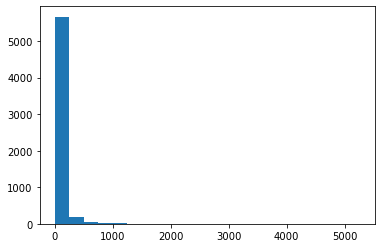

In [26]:
import matplotlib.pyplot as plt

bins = np.arange(frequencies[1].min(), frequencies[1].max()+1, 250)
print(bins)
plt.hist(frequencies[1], bins=bins)


In [27]:
# calculate the kl divergence
# https://machinelearningmastery.com/divergence-between-probability-distributions/
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.rel_entr.html
from scipy.special import rel_entr

kld = df.apply(lambda x: rel_entr(tfidf.transform(cv.transform([x.unknown])).toarray(), 
                    tfidf.transform(cv.transform([x.known])).toarray()).sum(axis=1)[0], axis=1)

In [28]:
for i in range (df.shape[0]):
    x = df.loc[i]
    print(x.unknown[:10])
    print(x.known[:10])
    tfidf_u = tfidf.transform(cv.transform([x.unknown])).toarray()
    tfidf_k = tfidf.transform(cv.transform([x.known])).toarray()
    e = rel_entr(tfidf_u, tfidf_k).sum(axis=1)[0]
    print(tfidf_u)

Oh, he's c
My, my, I 
[[0. 0. 0. ... 0. 0. 0.]]
But speed 
Sir, you a
[[0. 0. 0. ... 0. 0. 0.]]
But the gr
God!  What
[[0. 0. 0. ... 0. 0. 0.]]
It turns t
Sullen nig
[[0. 0. 0. ... 0. 0. 0.]]
Who'll it 
Gimme a sh
[[0. 0. 0. ... 0. 0. 0.]]
I agree. P
After that
[[0. 0. 0. ... 0. 0. 0.]]
Whoa, ther
Hurrah, hu
[[0. 0. 0. ... 0. 0. 0.]]
Nora Eudor
Don't brin
[[0. 0. 0. ... 0. 0. 0.]]
Won't it b
And say, "
[[0. 0. 0. ... 0. 0. 0.]]
Oh, come o
Instead of
[[0. 0. 0. ... 0. 0. 0.]]
Come and s
Not for mi
[[0. 0. 0. ... 0. 0. 0.]]
No--of cou
Aw, goin' 
[[0. 0. 0. ... 0. 0. 0.]]
In serving
Bow impres
[[0. 0. 0. ... 0. 0. 0.]]
I forget n
In short, 
[[0.         0.         0.         ... 0.03461499 0.         0.        ]]
Ay know it
And now to
[[0. 0. 0. ... 0. 0. 0.]]
That's bec
Whoa, ther
[[0.06639603 0.         0.         ... 0.         0.         0.        ]]
Well, I ha
It's a won
[[0. 0. 0. ... 0. 0. 0.]]
Lads like 
Oh, 'tis y
[[0. 0. 0. ... 0. 0. 0.]]
Oh, for he
Oh, 'tis y
[[0.03031384 0.   

In [195]:
np.unique(kld)

array([inf])

In [29]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
from sklearn.metrics.pairwise import cosine_similarity

coss_tf = cosine_similarity(cv.transform(df.unknown), cv.transform(df.known))
coss_tfidf = cosine_similarity(tfidf.transform(cv.transform(df.unknown)), tfidf.transform(cv.transform(df.known)))


In [103]:
type(kld)

pandas.core.series.Series

In [30]:
df.assign(tf = lambda x: coss_tf[x.index, x.index],
    tfidf = lambda x: coss_tfidf[x.index, x.index], 
    kld = kld
    ).sort_values(by='tf', ascending=False)
# df['kld'] = kld.flatten()

,id,unknown,known,truth,tf,tfidf,kld
64,EN065,"You mutt, you! I've stood enough from you. Don...","I can't, Annie. Why can't you? A woman couldn'...",Y,0.783151,0.632438,inf
68,EN069,Mush! Indade and I will ask your pardon a tho...,"I can't, Annie. Why can't you? A woman couldn'...",Y,0.761971,0.616135,inf
52,EN053,"God blast it! No, your kind never realises thi...","Don't be standin' there like a hawk, Harpooner...",Y,0.758615,0.592032,inf
38,EN039,"Oh, 'tis you, is it? What're ye shiverin' 'bou...","Yes--we'll wait--certainly, we're all right. I...",Y,0.757663,0.614464,inf
77,EN078,Attacking across open ground: four machine bul...,It's a wonder you wouldn't stop this machine g...,N,0.750979,0.577555,inf
...,...,...,...,...,...,...,...
67,EN068,"Things are seldom what they seem, Skim milk ma...","Serve ye right, ye old divil--havin' a woman a...",N,0.466938,0.246317,inf
7,EN008,"Nora Eudora, darlin', have ye got a sofy pillo...",Don't bring Hannibal in till I know where she'...,N,0.462708,0.263784,inf
8,EN009,Won't it be a pretty wedding? Will not Lisa lo...,"And say, ""How clever!"" At whatsoever She conde...",Y,0.458969,0.292537,inf
49,EN050,Dogs take to her. That's a sure sign. Little ...,Mr Foreson? Sir? We'll do that lighting again....,Y,0.452439,0.241315,inf


In [74]:
df.head()

KeyError: 'kld'